## Motivation: The number of proton-proton collision events at the Large Hadron Collider, at CERN is huge. Recording and storing all this information is a challenge for the project. Therefore, the ATLAS experiment uses a trigger-system, which selects and sends interesting events to the data storage system. (More about ATLAS: https://atlas.cern/discover/about)

<img src="./storage.png" alt="Drawing" style="width: 600px;"/>

The above graph shows the estimation of disk storage in the near future. 
(Source of the above image: https://twiki.cern.ch/twiki/bin/view/AtlasPublic/ComputingandSoftwarePublicResults)

Even after the reduced storage model, we require a lot of disk storage.
### Can we reduce our data storage and store only useful information?

Enormous Data, Data Compression, Useful Data Extraction. Sounds like Deep Learning would love to handle this task.

Apart from Deep Learning, there are other Machine Learning algorithms that can help extract useful information from the data and reduce the dimensionality. 

Dimensionality Reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. This can be done by feature selection or feature extraction.

Feature extraction transforms the data in a high-dimensional space to a low-dimesional space.

One of the linear feature extraction transformation is Principal Component Analysis (PCA).
PCA is an orthogonal projection or transformation of the data into a (possibly lower dimensional) subspace so that the variance of the projected data is maximized. 

(Source: http://www.cs.cmu.edu/~ninamf/courses/601sp15/slides/22_pca-04-09-2015.pdf)

As PCA is a linear transformation, it might lose information if the features have a non-linearity relation among them. We can use Kernel PCA to include non-linearity, however, this model will be restricted by kernel's representation ability. Any other complex function might not be projected by Kernel PCA.

On the other hand, autoencoders use Neural Networks, and NNs can represent complex functions. Therefore, if we have a large dataset, and complex functions, autoencoders can give us pretty good compression with less information loss. 

Let's look at the performance of PCA and autoencoders on a few functions:

<img src="./pca_autoencoders.png" alt="Drawing" style="width: 800px;"/>

Source of the image: https://towardsdatascience.com/autoencoders-vs-pca-when-to-use-which-73de063f5d7

Therefore, for our original dataset (27 variables), autoencoders are the best candidates for data compression.

Let's understand the principle of dimensionality reduction with the help of an encoder and a decoder:

<img src="./compression.png" alt="Drawing" style="width: 1000px;"/>

Source of the above image: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

An autoencoder is a model that uses neural networks for an encoder and a decoder. Neural Networks follow Gradient Descent for optimization. In the case of an autoencoder, mean squared error (MSE) is a good measurement of the how well the autoencoder is performing.

<img src="./autoencoder.png" alt="Drawing" style="width: 1000px;"/>

Source of the above image: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

### Before reducing the dimensionality of 27 variables, let us get the best parameters and finetune our autoencoder for 4 variables.

Analyzing the autoencoder for 4 variables and finetuning it will save a lot of time, and will help us understand the whole architecture of an autoencoder in depth.

### Goal: Prepare an autoencoder to convert the given dataset from 4 variables to 3 variables.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

# Read from Pickle file

### Training Data

In [3]:
train = pd.read_pickle("dataset/all_jets_train_4D_100_percent.pkl")
train.head()

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


### Test Data

In [4]:
test = pd.read_pickle("dataset/all_jets_test_4D_100_percent.pkl")
test.head()

,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


# Data Analysis
Number of Training set examples: 111,778 

Number of Test set examples: 27,945

Train/Test Percentage: 60:40

## Visualization

In [5]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(10)
import seaborn as sns; sns.set(color_codes=True)

Code inspired from (https://github.com/Skelpdar/HEPAutoencoders/blob/master/process_ROOT_4D.ipynb)

In [6]:
# Store all the figures in the figures/ folder
figures_folder = 'figures/'

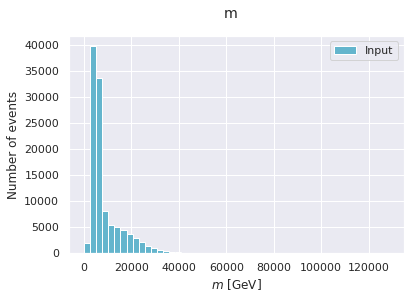

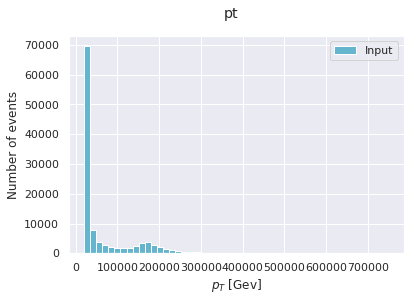

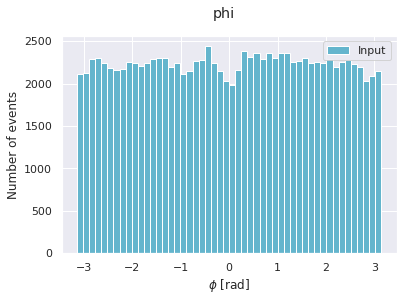

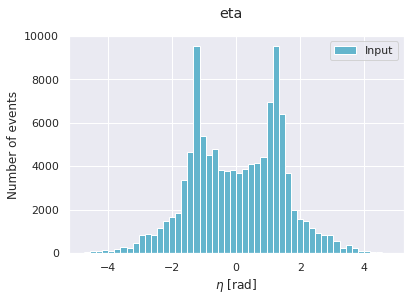

In [7]:
plt.close('all')
unit_list = ['[GeV]', '[Gev]', '[rad]', '[rad]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

# Histograms
alpha = 1
n_bins = 50
for i in np.arange(4):
    plt.figure(i + 4)
    n_hist_data, bin_edges, _ = plt.hist(train.iloc[:,i], color=colors[1], label='Input', alpha=alpha, bins=n_bins)
    plt.suptitle(test.columns[i])
    plt.xlabel(variable_list[i] + ' ' + unit_list[i])
    plt.ylabel('Number of events')
    plt.legend()
    fig_name = 'train_data_hist_%s' % train.columns[i]
#     plt.savefig(figures_folder + fig_name)

### Mean and Std of each variable

In [8]:
print("Std:\n", train.std())
print("Mean:\n", train.mean())

Std:
 m       7421.270111
pt     69874.993026
phi        1.803151
eta        1.448439
dtype: float64
Mean:
 m       8941.356799
pt     64458.683471
phi        0.001691
eta        0.043500
dtype: float64


### Looking at the above values, it is better to scale all the 4 variables for our NN to converge faster.

## Data Preprocessing
#### Why scaling helps: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Scaling some features
# MinMax scaler preseves the shape, range is 0-1, doesn't reduce the outliers. Usually a good start.
# scaler = MinMaxScaler()

# Better for NNs, mean = 0, variance = 1. Normalizes your data. If you have outliers, this will be a good scale.
scaler = StandardScaler()

# Always use training data for fitting. In real scenarios, you don't have the mean and std of the test data.
scaler.fit(train[['m', 'pt', 'phi', 'eta']])

# NN works best with scaled data
train[['m', 'pt', 'phi', 'eta']] = scaler.transform(train[['m', 'pt', 'phi', 'eta']])

test[['m', 'pt', 'phi', 'eta']] = scaler.transform(test[['m', 'pt', 'phi', 'eta']])

train.head()

,m,pt,phi,eta
132784,-0.688499,-0.607632,0.868110,0.759044
99666,-0.587360,-0.612675,-1.487541,0.117475
26629,1.051901,1.503486,-1.081406,0.773109
80473,0.788040,1.697710,-0.911072,1.813980
48229,-0.578695,-0.628719,1.619716,-0.830119


### Plot the scaled data

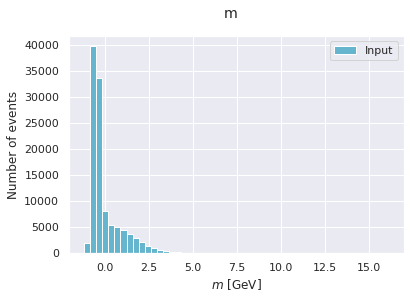

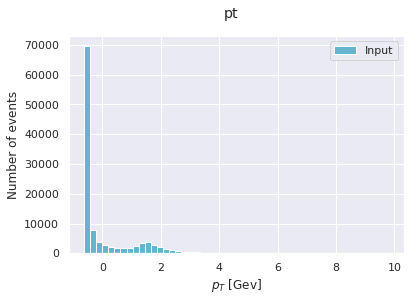

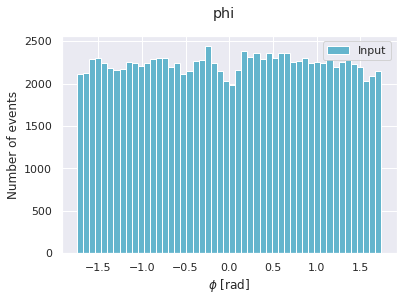

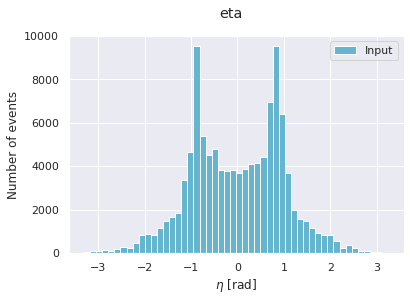

In [10]:
plt.close('all')
unit_list = ['[GeV]', '[Gev]', '[rad]', '[rad]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

# Histograms
alpha = 1
n_bins = 50
for i in np.arange(4):
    plt.figure(i + 4)
    n_hist_data, bin_edges, _ = plt.hist(train.iloc[:,i], color=colors[1], label='Input', alpha=alpha, bins=n_bins)
    plt.suptitle(test.columns[i])
    plt.xlabel(variable_list[i] + ' ' + unit_list[i])
    plt.ylabel('Number of events')
    plt.legend()
    fig_name = 'train_data_hist_%s' % train.columns[i]
#     plt.savefig(figures_folder + fig_name)

### Loading the saved autoencoder model

In [11]:
from fastai import data_block, basic_train, basic_data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from fastai.callbacks import ActivationStats
from fastai import train as tr
import torch
from fastai.basics import DataBunch, Path, nn, ClassificationInterpretation
from HEPAutoencoders.nn_utils import AE_big, AE_3D_200

In [12]:
x_train = np.array(train, dtype=np.float32)
x_test= np.array(test, dtype=np.float32)

In [14]:
x_train.dtype

dtype('float32')

In [15]:
# x == y because this is an autoencoder.
x_train = y_train = x_train
x_valid = y_valid = x_test

bs=256
train_ds = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
valid_ds = TensorDataset(torch.tensor(x_valid), torch.tensor(y_valid))

data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [16]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([256, 4]), torch.Size([256, 4]))

In [17]:
data

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f43edd63d90>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f43983d66d0>;

Test: None

In [18]:
model = AE_3D_200()
model_path = '/home/pbaweja/autoencoder/HEPAutoencoders/4D/models/AE_3D_200_no1cycle_trainforever'
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
loss_func = nn.MSELoss()

In [19]:
learn = basic_train.Learner(data=data, 
                            model=model, 
                            loss_func=loss_func, 
                            wd=wd,
                            callback_fns=ActivationStats, 
                            bn_wd=bn_wd, true_wd=true_wd)

### We already have a trained model from Github (https://github.com/Skelpdar/HEPAutoencoders). I will load that model.

In [20]:
learn.load(model_path)

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f43edd63d90>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f43983d66d0>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

### Validation Loss

In [21]:
learn.validate()

[0.50589246]

Let's train the model for a few more epochs.

### Fastai helps in finding the best learning rate for the model. 

In [22]:
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


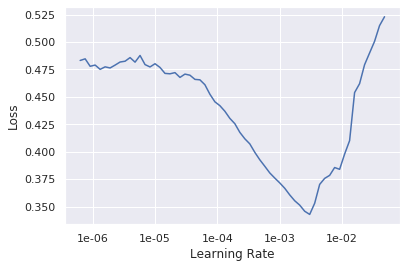

In [23]:
learn.recorder.plot()

In [24]:
lr = 3e-4
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.030258,0.029132,00:05
1,0.024728,0.025448,00:04
2,0.024071,0.024802,00:05
3,0.021921,0.023292,00:04
4,0.021339,0.022302,00:04
5,0.021143,0.021590,00:04
6,0.020632,0.021271,00:05
7,0.019927,0.020155,00:04
8,0.020038,0.019432,00:04
9,0.018332,0.019232,00:05


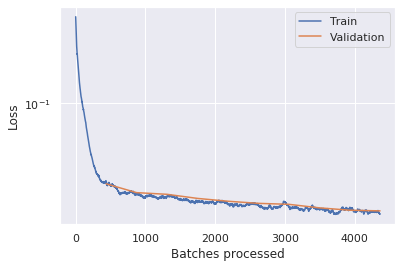

In [25]:
learn.recorder.plot_losses()
plt.yscale('log')

### Validation Loss

In [26]:
learn.validate()

[0.019232366]

### The trained model that is saved gives 50% validation loss. After training the model further for 10 epochs, we get down to ~2% validation loss.

Let's get the predicted data to visualize the performance of the autoencoder.

In [31]:
model.to('cpu')
x_test = torch.tensor(x_test)

In [32]:
x_test

tensor([[-0.5333, -0.5819,  1.0872, -0.0711],
        [-0.4724, -0.6093,  0.5733,  0.4770],
        [-0.4988, -0.5703, -0.6227,  0.5422],
        ...,
        [-0.5517, -0.5617, -1.2107, -1.6051],
        [-0.1767, -0.3924, -1.4821, -0.6032],
        [ 0.0446, -0.1671, -1.1240,  0.3776]])

In [33]:
pred = model(x_test).detach().numpy()

In [34]:
pred

array([[-0.509084, -0.615814,  1.085099, -0.06576 ],
       [-0.485258, -0.598302,  0.570309,  0.481909],
       [-0.483176, -0.598545, -0.628233,  0.538099],
       [ 0.607192,  1.738862,  0.1852  , -1.469093],
       ...,
       [-0.405194, -0.555613, -0.451022,  0.689724],
       [-0.546646, -0.55984 , -1.213162, -1.603645],
       [-0.162125, -0.416095, -1.487098, -0.593411],
       [ 0.100845, -0.23135 , -1.129393,  0.414894]], dtype=float32)

## Plotting the predicted data and original data

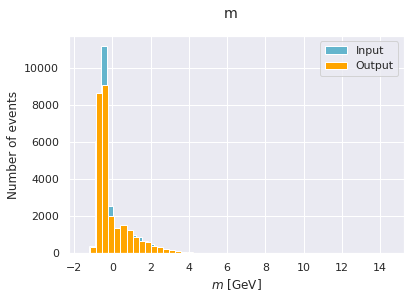

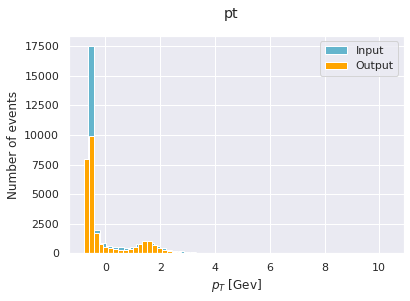

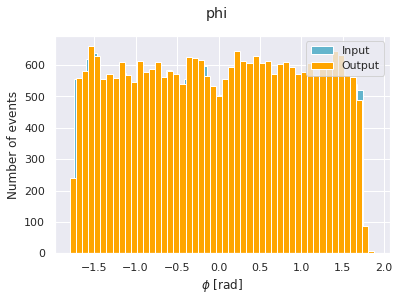

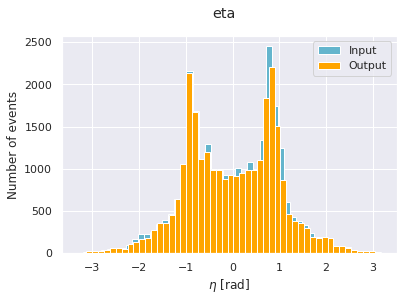

In [37]:
plt.close('all')
unit_list = ['[GeV]', '[Gev]', '[rad]', '[rad]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

# Histograms
alpha = 1
n_bins = 50
for i in np.arange(4):
    plt.figure(i + 4)
    n_hist_data, bin_edges, _ = plt.hist(x_test[:,i], color=colors[1], label='Input', alpha=alpha, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, i], color=colors[0], label='Output', alpha=alpha, bins=n_bins)
    plt.suptitle(train.columns[i])
    plt.xlabel(variable_list[i] + ' ' + unit_list[i])
    plt.ylabel('Number of events')
    plt.legend()
    fig_name = 'train_data_hist_%s' % train.columns[i]
#     plt.savefig(figures_folder + fig_name)

### The results on test dataset are pretty good. We can train the model more to get further improvements in the results, but there is a chance of overfitting.

## Anomaly Detection using Autoencoders

In [101]:
## Finding single-most anomalous data item for all the 4 variables.
N = x_test.shape[0]
mse_losses = {}
for i in range(N):
    mse_losses[i] = loss_func(x_test[i], torch.tensor(pred)[i])

### These are the top k anomalies in our dataset according to the mean squared error. 

In [102]:
k = 10
top_k_anomalies = sorted(mse_losses.items(), key=lambda x: x[1], reverse=True)[:k]

In [103]:
for i in range(10):
    print ("Dataset #%s: %s" %(top_k_anomalies[i][0], x_test[top_k_anomalies[i][0]]))

Dataset #27564: tensor([ 6.9125, 10.3283, -1.2359, -0.1189])
Dataset #25830: tensor([ 1.9656,  3.8056, -0.0193,  1.5240])
Dataset #2676: tensor([1.3603, 3.4524, 1.5454, 1.3151])
Dataset #21462: tensor([0.9118, 3.3996, 0.0817, 1.4197])
Dataset #24793: tensor([1.6079, 3.4667, 1.4650, 1.1699])
Dataset #16549: tensor([-0.8665,  3.4464,  1.1612,  1.8157])
Dataset #20208: tensor([1.0472, 3.2065, 0.0370, 0.8383])
Dataset #8124: tensor([1.6693, 3.4794, 0.6776, 1.1820])
Dataset #1520: tensor([3.2053, 3.9385, 0.3604, 1.2375])
Dataset #27829: tensor([-0.7639,  1.9083,  1.6228, -0.1221])


### Think about the Future work